In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bagpipes as pipes
from PyAstronomy import pyasl
from astropy.cosmology import FlatLambdaCDM
import json
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

import sys
sys.path.append('../..')
# adds in additional chemical evolution models to bagpipes
from code_bits.add_ceh_funcs import *
# adds in additional GP noise kernels to bagpipes
from code_bits.add_GP_SHOTerm import *
# adds in VW07 dust to bagpipes
from code_bits.add_VW07_dust import *
# import a bunch of useful functions for interfacing with bagpipes
from code_bits.fitting_MaNGA import *

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


### Masking
There are four main types of things that I mask:
- Major nebular emission lines since I do not include a nebular emission model in my Bagpipes fits. These are specified in rest-frame wavelengths in fitting_MaNGA.fitting
- skylines since their removal during the data reduction process can create nasty spikes and dips in the spectra, masked in obs frame, defined in `skylines.txt`
- Balmer infilling. All Balmer lines from Hepsilon to H13 have their central ~2.6 AA portion masked
- Extra galaxy-specific masking. These are done through visual inspection: If a defact is seen in the form of a large residual spike after the first round of fitting, the galaxy is re-fitted after the masking is added in `extra_masking.txt`

These are handelled by the fitting_MaNGA.fitting class.

### The spectrum .csv file
After stacking the MaNGA spaxels, I like to save the stacked spectra in .csv files. Each of these have 3 columns, with column names: <br>
`observed-wave[AA]`, `flux[10^-16 erg/s/cm^2/AA]`, `noise[10^-16 erg/s/cm^2/AA]`
<br>
The last two columns are in the order of $10^{-16}$. The functions in fitting_MaNGA.fitting assumes this data structure

### Loading in the spectrum and masking with fitting_MaNGA.fitting class

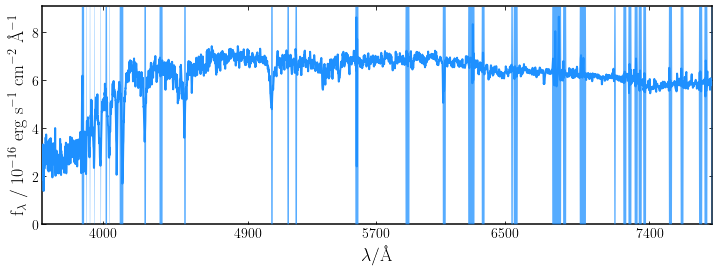

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-16}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [2]:
skylines_path = '.'
data_path = 'MaNGA_spectrum'
z = 0.03858788035124397       # from MaNGA's DRPall
binby = 1                     # binby N = to bin input spectrum by every N bins, reducing
                              # the spectral resolution by N folds
full = False                  # if full == False: limits to MILES range (max 7500 in rest-frame)

fit_obj = fitting(skylines_path, data=data_path, z=z, binby=binby, full=full, sky_masking=True)
# galID has to match the name of the file in the data_path that is to be loaded in
galID = '10838-1902_PSBonly_dereddened'
galaxy = pipes.galaxy(galID, fit_obj.load_manga_spec, photometry_exists=False)
galaxy.plot()

### Alternatively, to make the settings and configs clear and organized across variations, using a `run_param` dictionary to pass all configs

In [18]:
run_params = {}

# input spectrum params
run_params["ID_plateifu"] = "10838-1902"
run_params['data_file_extension'] = '_PSBonly_dereddened'
run_params['galID'] = run_params['ID_plateifu']+run_params['data_file_extension']
run_params['bin_by'] = 1
run_params['spectrum_dir'] = 'MaNGA_spectrum'         # directory where the spectrum is stored, also where 
                                                      # additional masking files (e.g. extra_skylines.txt) are
run_params['z'] = 0.03858788035124397

# fitting params
run_params['runID_extension'] = '_PSBsummed_P32_no_red_phot_dereddened_binby1_Rspec4340_GPSHOTerm2_zmet2step'
run_params['runID'] = run_params["ID_plateifu"] + run_params['runID_extension']
run_params['Rspec'] = 4340
run_params['red_phot'] = False                        # whether to convert the dropped red end of the spectrum 
                                                      # into a single photometric measurement and fitted jointly
run_params['dust_type'] = "VW07"
run_params['GP'] = True
run_params['GPtype'] = 'GP_SHOTerm2'                  # GP noise kernel choice
run_params['SHOTerm_period_prior'] = (0.04,1.0)       # lengthscale prior of the GP noise curve
run_params['eta'] = (1.0, 5.0)                        # dust law eta (equals to 1/mu in some papers)
run_params['burstage'] = (0.0, 4.0)
run_params['SFHcomp'] = 'psb_wild2020'                # SFH model choice
run_params['ceh'] = 'twostep'                         # stellar metallicity model choice
run_params['zmet_prior'] = 'log_10'                   # shape of any priors to do with metallicity
run_params['SHOTerm_norm_prior'] = (0.0001,0.1)       # amplitude of the GP noise curve (prior on the std)
run_params['n_live'] = 400                            # number of live points of multinest sampler

# the dictionary can then be saved as a json file
os.mkdir('pipes/posterior/'+run_params['runID'])
a_file = open('pipes/posterior/'+run_params['runID']+'/'+run_params['galID']+".json", "w")
json.dump(run_params, a_file)
a_file.close()

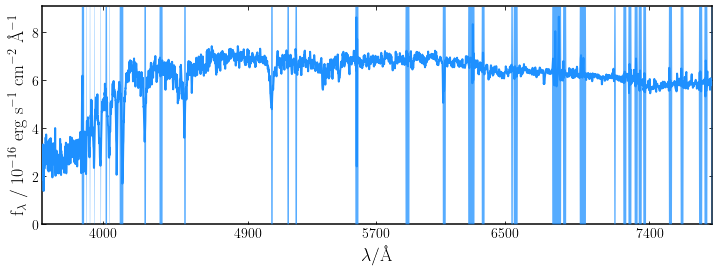

(<Figure size 864x288 with 1 Axes>,
 [<AxesSubplot:xlabel='$\\lambda / \\mathrm{\\AA}$', ylabel='$\\mathrm{f_{\\lambda}}\\ \\mathrm{/\\ 10^{-16}\\ erg\\ s^{-1}\\ cm^{-2}\\ \\AA^{-1}}$'>])

In [19]:
fit_obj = fitting(skylines_path, run_params=run_params, full=False, sky_masking=True)
# galID has to match the name of the file in the data_path that is to be loaded in
galaxy = pipes.galaxy(run_params['galID'], fit_obj.load_manga_spec, photometry_exists=False)
galaxy.plot()

### Make fitting instructions

In [21]:
def get_fit_instructions(redshift, GP=True, dust_type="CF00", eta=(1.0, 3.0), burstage=(0, 2), 
                         ceh='default',
                         zmet_prior=None, GPtype=None, SHOTerm_period_prior=None, SHOTerm_norm_prior=None):
    """ Set up the desired fit_instructions dictionary. """
    dust = {}
    dust["type"] = dust_type
    dust["eta"] = eta
    dust["Av"] = (0., 2.0)
    if dust_type == "CF00":
        dust["n"] = 0.7
    
    psb = {}
    psb["age"] = (4, 14.)                     # Vary age between 4 Myr and 14 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.
    psb["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
    psb["massformed"] = (6, 13)              # vary log_10(M*/M_solar) between 1 and 15

    psb["burstage"] = burstage                   # age of burst from 0 to 2Gyr
    psb["alpha"] = (0.01,1000)               # decline of burst
    psb["alpha_prior"] = "log_10"
    psb["beta"] = 250.                    # rise of burst: fixed
    psb["fburst"] = (0,1)
        
    if ceh == 'default':
        psb["metallicity_type"] = 'delta'
        psb["metallicity"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
        if zmet_prior is not None:
            psb["metallicity_prior"] = zmet_prior
    elif ceh == 'twostep':
        psb["metallicity_type"] = "psb_two_step"
        psb["metallicity_old"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
        psb["metallicity_burst"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
        psb["metallicity_scatter"] = "delta"
        if zmet_prior is not None:
            psb["metallicity_old_prior"] = zmet_prior
            psb["metallicity_burst_prior"] = zmet_prior
    elif ceh == 'twostep_free':
        psb["metallicity_type"] = "two_step"
        psb["metallicity_old"] = (0.01, 2.5) 
        psb["metallicity_new"] = (0.01, 2.5) 
        psb["metallicity_step_age"] = (0,8)
        psb["metallicity_scatter"] = "delta"
        if zmet_prior is not None:
            psb["metallicity_old_prior"] = zmet_prior
            psb["metallicity_new_prior"] = zmet_prior
    
    noise = {}
    noise["scaling"] = (0.1, 10.)
    noise["scaling_prior"] = "log_10"
    if GP == False:
        noise["type"] = "white_scaled"
    else:
        if GPtype == 'GP_SHOTerm' or GPtype == 'GP_SHOTerm2':
            noise["period"] = SHOTerm_period_prior
            noise["period_prior"] = "log_10"
            noise["Q"] = 0.49
            noise["norm"] = SHOTerm_norm_prior
            noise["norm_prior"] = "log_10"
        elif GPtype == 'GP_exp_squared':
            noise["length"] = (0.01, 10.)
            noise["length_prior"] = "log_10"
            noise["norm"] = (0.01, 1.)
            noise["norm_prior"] = "log_10"
        noise["type"] = GPtype
    
    fit_instructions = {}
    fit_instructions["dust"] = dust
    fit_instructions["psb_wild2020"] = psb
    fit_instructions["noise"] = noise
    fit_instructions["t_bc"] = 0.01
    fit_instructions["veldisp"] = (40., 4000.)
    fit_instructions["veldisp_prior"] = "log_10"
    fit_instructions['redshift'] = (redshift-0.2*redshift, redshift+0.2*redshift)
    
    return fit_instructions

fit_instructions = get_fit_instructions(
    run_params['z'], 
    GP = run_params['GP'], 
    dust_type = run_params['dust_type'],
    eta = run_params['eta'],
    burstage = run_params['burstage'], 
    ceh = run_params['ceh'],
    zmet_prior = run_params['zmet_prior'],
    GPtype = run_params['GPtype'],
    SHOTerm_period_prior = run_params['SHOTerm_period_prior'],
    SHOTerm_norm_prior = run_params['SHOTerm_norm_prior']
)

In [22]:
# set the R_spec according to run_params
pipes.config.R_spec = run_params['Rspec']

# fitting
fit = pipes.fit(galaxy, fit_instructions, run=run_params['runID'], time_calls=False)
        
fit.fit(verbose=False, n_live=run_params['n_live'])


Bagpipes: fitting object 10838-1902_PSBonly_dereddened


Completed in 7638.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        1.032      1.069      1.105
dust:eta                       1.748      3.096      4.359
noise:norm                     0.010      0.011      0.012
noise:period                   0.050      0.060      0.074
noise:scaling                  4.455      4.512      4.569
psb_wild2020:age               4.404      5.560      7.523
psb_wild2020:alpha            84.009    103.507    126.688
psb_wild2020:burstage          0.579      0.607      0.727
psb_wild2020:fburst            0.213      0.242      0.300
psb_wild2020:massformed       10.070     10.109     10.159
psb_wild2020:metallicity_burst      1.949      2.210      2.390
psb_wild2020:metallicity_old      0.262      0.300      0.330
psb_wild2020:tau     

### Making some plots

In [23]:
# Built in bagpipes plots
# spectrum fits plot
fig = fit.plot_spectrum_posterior(show=True, save=True)
# posterior SFH plot
fig = fit.plot_sfh_posterior(show=True, save=True)
# corner plot
fig = fit.plot_corner(show=True, save=True)

10838-1902_PSBonly_dereddened


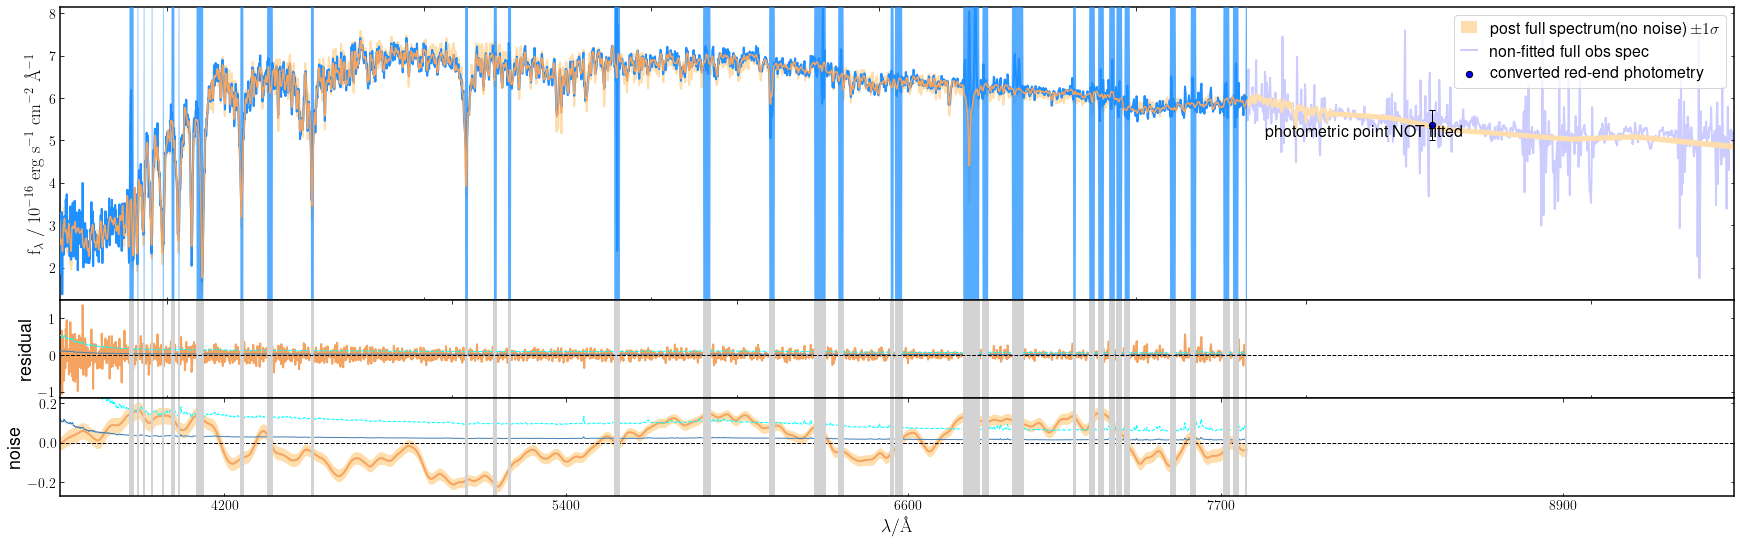

In [24]:
# custom plots included in fitting_MaNGA.py
# spectrum fits plot that also shows residuals and the GP noise spectrum
fig, axes = plot_spec(fit, fit_obj, figsize=(30,9), save=True)

posterior f_burst and t_burst: [0.21539197 0.24390397 0.29884914] [12.21553682 12.33540903 12.36336149]


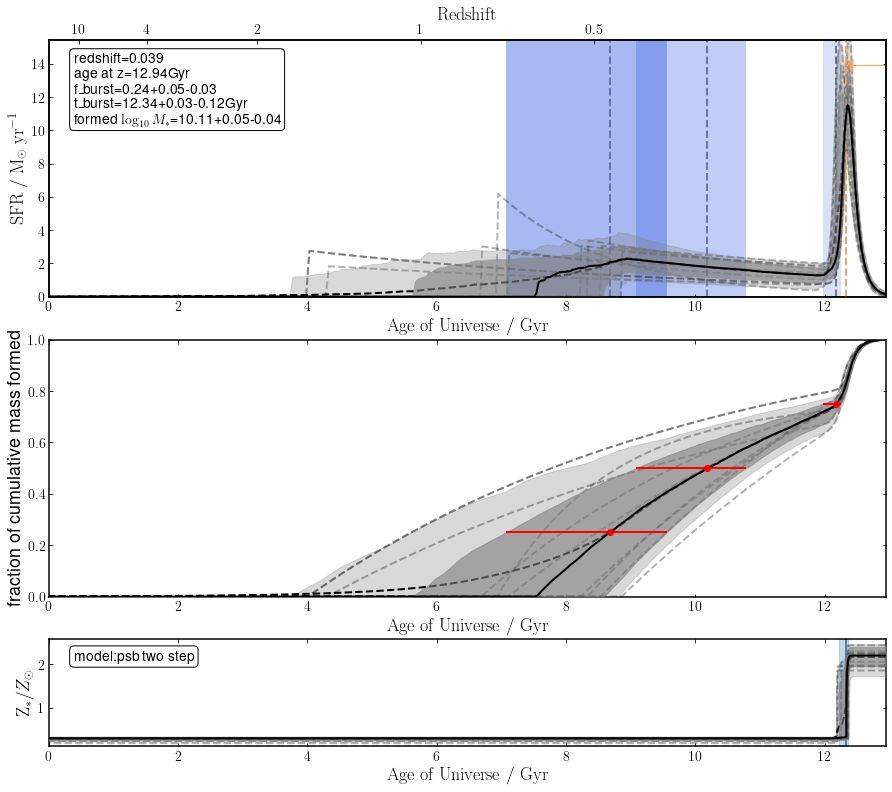

(<Figure size 1080x936 with 4 Axes>,
 [<AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{SFR\\ /\\ M_\\odot\\ \\mathrm{yr}^{-1}}$'>,
  <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='fraction of cumulative mass formed'>,
  <AxesSubplot:xlabel='$\\mathrm{Age\\ of\\ Universe\\ /\\ Gyr}$', ylabel='$\\mathrm{Z_{*}}/Z_{\\odot}$'>])

In [25]:
# SFH plot that has 3 panels
plot_sfh(fit, save=True, plot_mean=True, ninty_region=True, samples=10)